In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

Using device: cpu


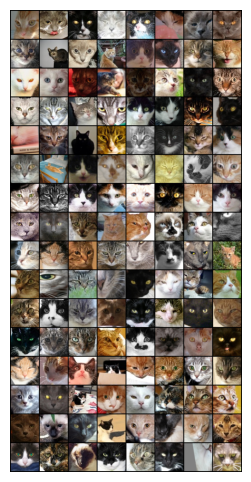

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set your dataset path here
data_path = r"C:\Users\Ksawery\Desktop\gitbub-repos\dl-generative\photos\cats\Data"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

# Show a batch of training data
def show_images(imgs, nrow=8):
    imgs = (imgs * 0.5 + 0.5).clamp(0, 1)  # unnormalize
    grid = torchvision.utils.make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

show_images(next(iter(train_loader))[0])


In [10]:
class Encoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)


class Decoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 8, 8)
        return self.deconv(x)


class VAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = Decoder(img_channels, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, x_hat, x, mu, logvar):
        recon = F.mse_loss(x_hat, x, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kld, recon, kld


In [11]:
class Encoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)


class Decoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 8, 8)
        return self.deconv(x)


class VAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = Decoder(img_channels, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, x_hat, x, mu, logvar):
        recon = F.mse_loss(x_hat, x, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kld, recon, kld


Epoch 1/20:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 234/234 [02:44<00:00,  1.42it/s]


Epoch 1: loss = 0.1980


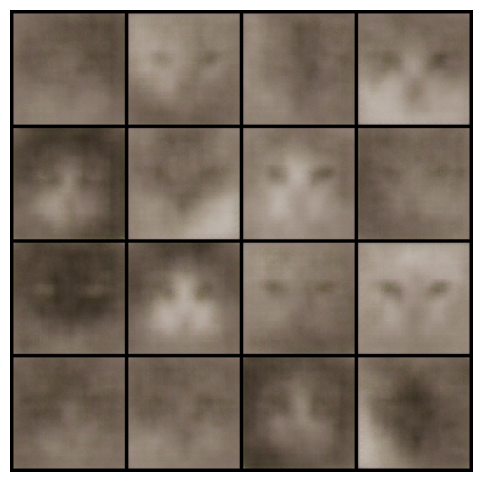

Epoch 2/20: 100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch 2: loss = 0.1769


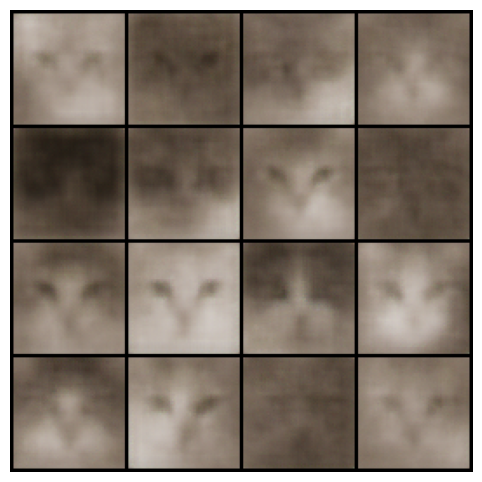

Epoch 3/20: 100%|██████████| 234/234 [01:28<00:00,  2.66it/s]

Epoch 3: loss = 0.1647


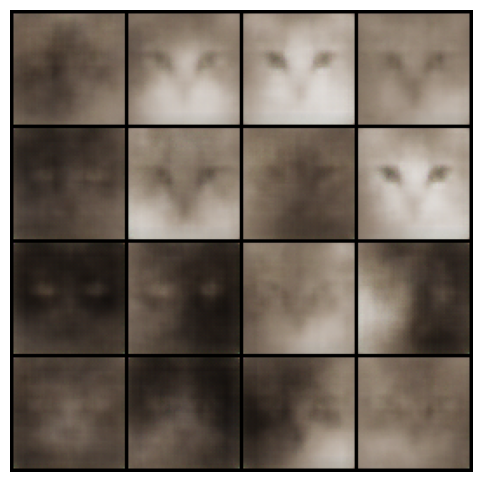

Epoch 4/20: 100%|██████████| 234/234 [01:15<00:00,  3.11it/s]

Epoch 4: loss = 0.1593


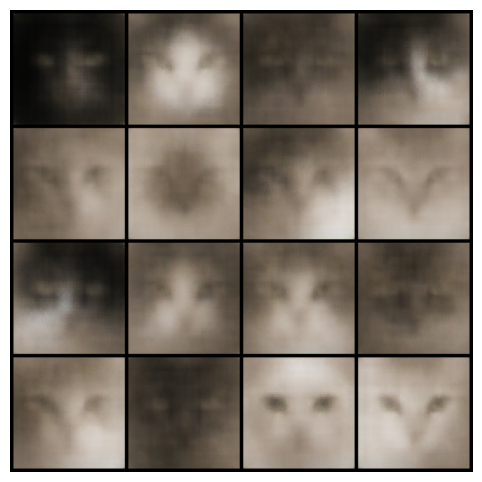

Epoch 5/20: 100%|██████████| 234/234 [01:15<00:00,  3.12it/s]

Epoch 5: loss = 0.1556


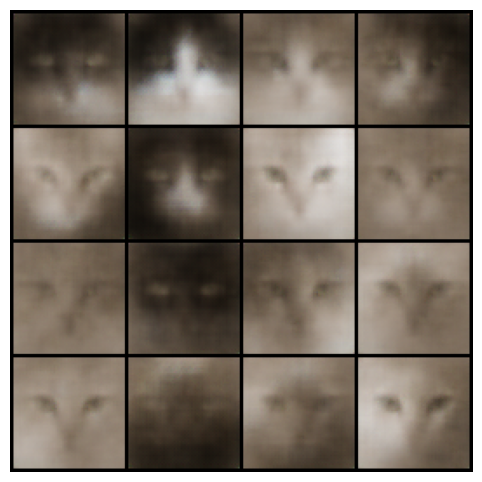

Epoch 6/20: 100%|██████████| 234/234 [01:15<00:00,  3.10it/s]

Epoch 6: loss = 0.1551


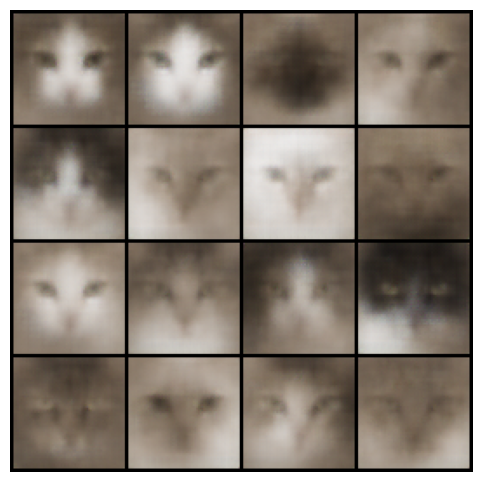

Epoch 7/20: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]

Epoch 7: loss = 0.1548


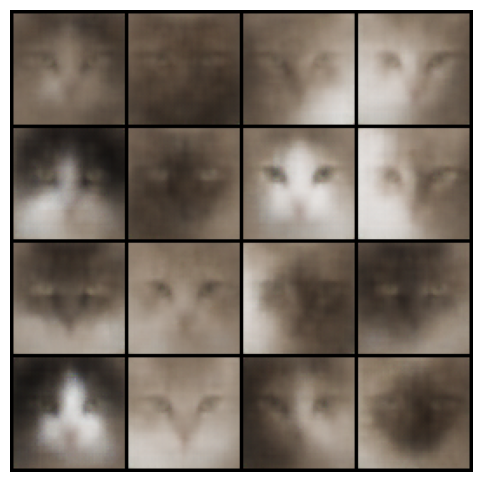

Epoch 8/20: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]

Epoch 8: loss = 0.1543


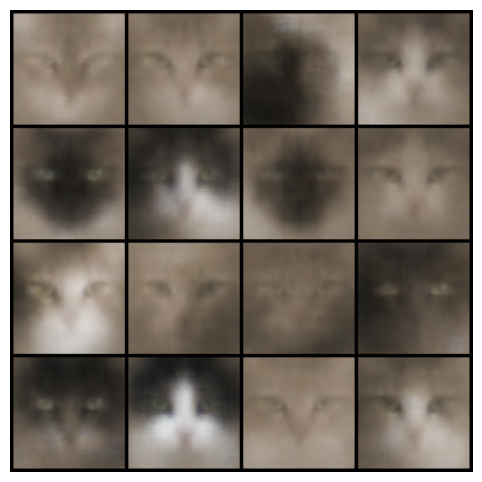

Epoch 9/20: 100%|██████████| 234/234 [01:18<00:00,  3.00it/s]


Epoch 9: loss = 0.1539


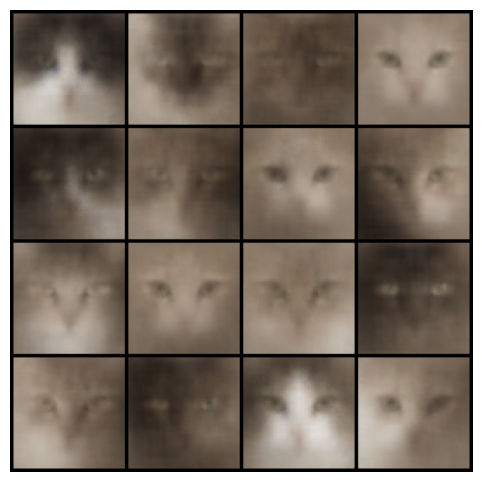

Epoch 10/20: 100%|██████████| 234/234 [01:15<00:00,  3.10it/s]

Epoch 10: loss = 0.1539


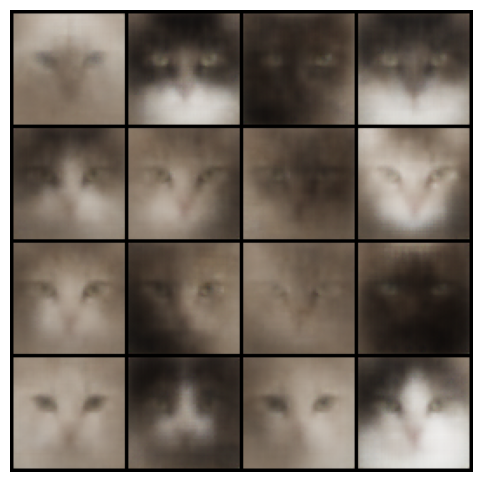

Epoch 11/20: 100%|██████████| 234/234 [01:28<00:00,  2.66it/s]

Epoch 11: loss = 0.1537


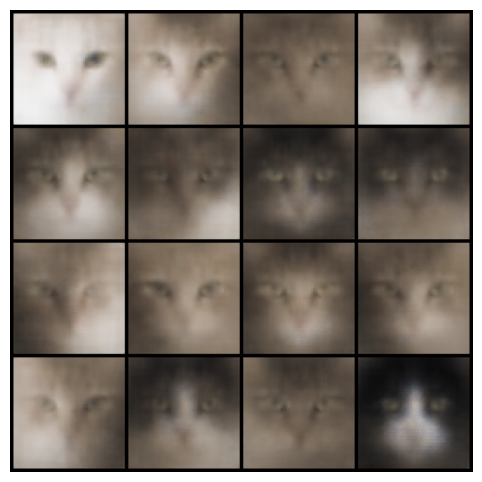

Epoch 12/20: 100%|██████████| 234/234 [02:18<00:00,  1.69it/s]

Epoch 12: loss = 0.1535


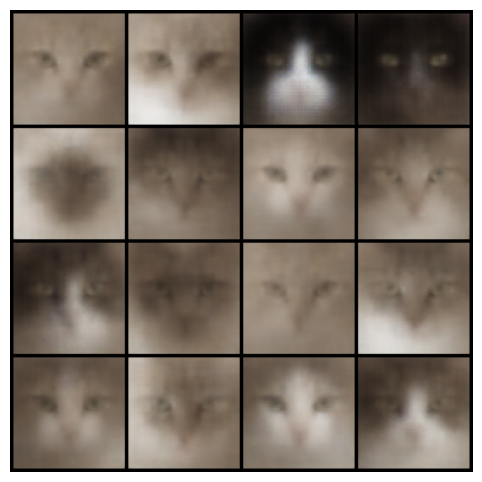

Epoch 13/20: 100%|██████████| 234/234 [01:16<00:00,  3.08it/s]

Epoch 13: loss = 0.1533


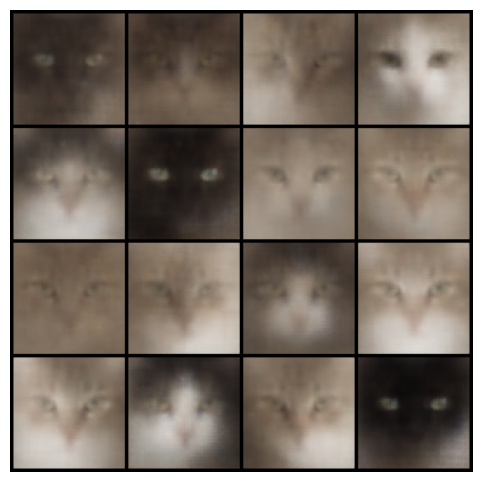

Epoch 14/20: 100%|██████████| 234/234 [01:16<00:00,  3.05it/s]

Epoch 14: loss = 0.1532


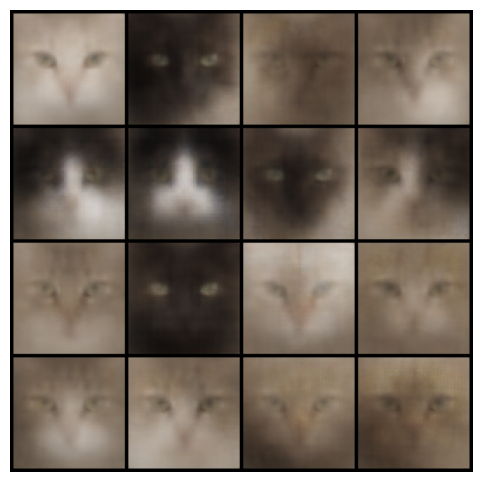

Epoch 15/20: 100%|██████████| 234/234 [01:16<00:00,  3.05it/s]


Epoch 15: loss = 0.1534


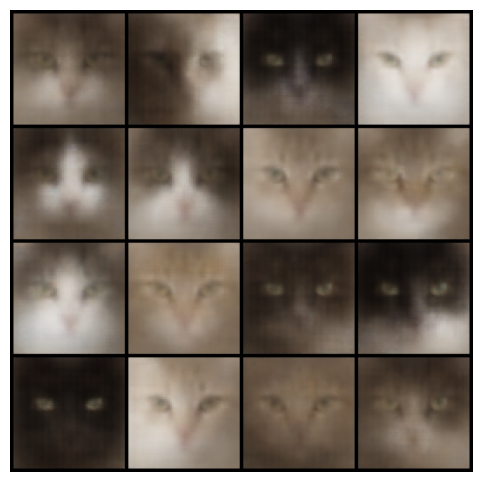

Epoch 16/20: 100%|██████████| 234/234 [01:15<00:00,  3.09it/s]

Epoch 16: loss = 0.1526


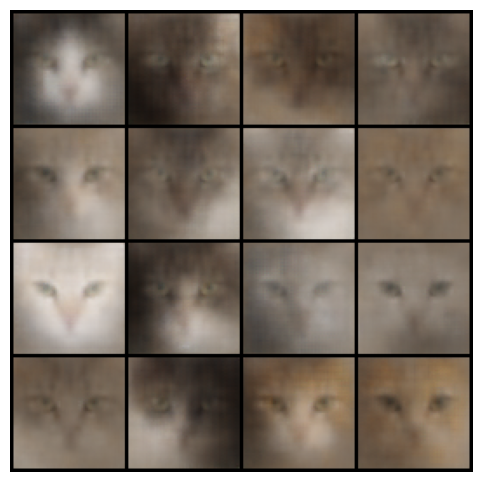

Epoch 17/20: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]

Epoch 17: loss = 0.1526


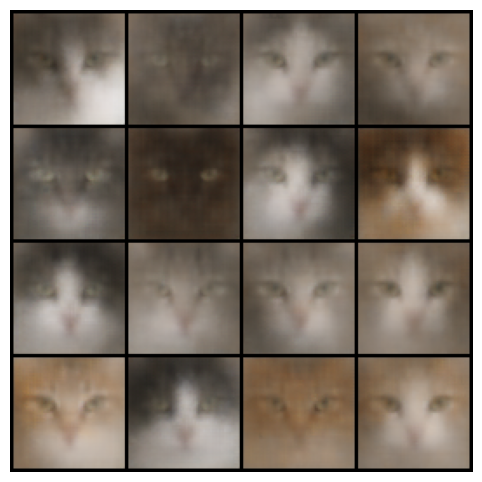

Epoch 18/20: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]

Epoch 18: loss = 0.1526


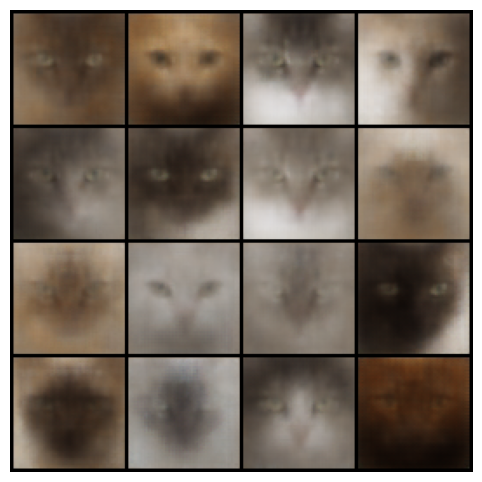

Epoch 19/20: 100%|██████████| 234/234 [01:18<00:00,  3.00it/s]

Epoch 19: loss = 0.1523


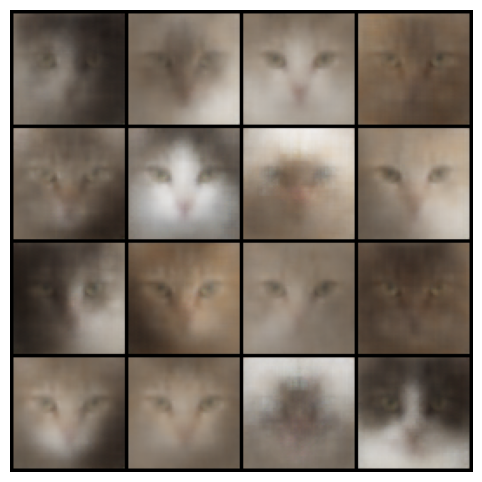

Epoch 20/20: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]

Epoch 20: loss = 0.1522


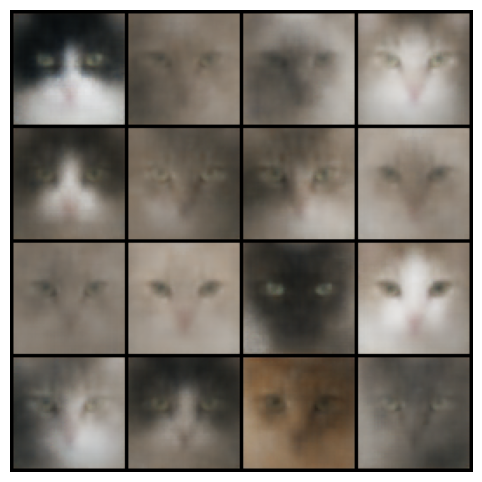

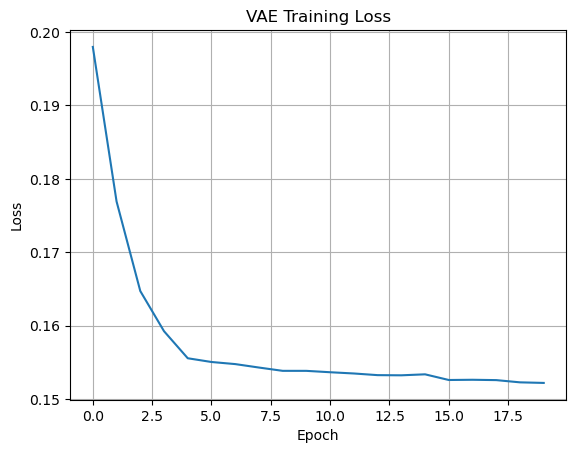

In [13]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 20
losses = []

for epoch in range(num_epochs):
    vae.train()
    running_loss = 0
    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x = x.to(device)
        x_hat, mu, logvar = vae(x)
        loss, recon, kld = vae.loss_function(x_hat, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")

    # Generate and show images
    with torch.no_grad():
        z = torch.randn(16, 128).to(device)
        samples = vae.decoder(z)
        show_images(samples.cpu(), nrow=4)


plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


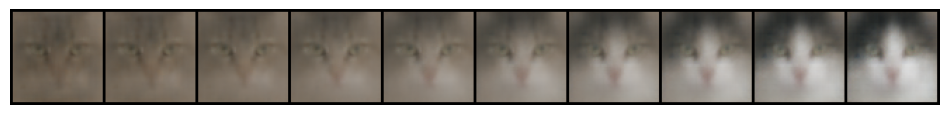

In [19]:
def interpolate(z1, z2, steps=8):
    return [z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, steps + 2)]

# Generate two random latent vectors
z1 = torch.randn(1, 128).to(device)
z2 = torch.randn(1, 128).to(device)

# Interpolate between them
interpolated_z = interpolate(z1, z2)

# Decode all to images
with torch.no_grad():
    decoded = [vae.decoder(z).cpu() for z in interpolated_z]
    imgs = torch.cat(decoded, dim=0)

# Show the 10 morphed images
show_images(imgs, nrow=10)


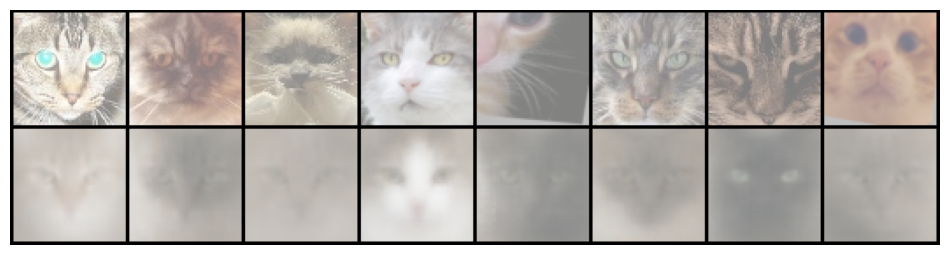

In [22]:
# Take a small batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:8].to(device)

# Encode and decode
with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    recon = vae.decoder(z).cpu()

# Unnormalize
real = real_imgs.cpu() * 0.5 + 0.5
recon = recon * 0.5 + 0.5

# Stack them vertically: real on top, reconstruction below
all_imgs = torch.cat([real, recon], dim=0)
show_images(all_imgs, nrow=8)
